# Debug Tmobile sjoin + overlay

`overlay` is taking a long time, but since there's a dissolve, it's basically 1 row for T-Mobile compared to 1 row for the district boundary. Might be able to treat them as GeoSeries and see if it can go through faster.

`difference` can also take multiple rows for T-Mobile compared to 1 row for district boundary. In this case, the dissolve for where there's no coverage for T-Mobile should take place after the difference is taken.

* `difference`: https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.difference.html


In [1]:
import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import pandas as pd

from calitp.sql import to_snakecase
import utilities

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
counties = utilities.get_counties()

# Read in original CT map
ct_all_districts = to_snakecase(
        gpd.read_file(f"{utilities.caltrans_shape}").to_crs(epsg=4326)
    )[["district", "geometry"]]
    

##### Sjoin  for T-Mobile by Districts
* Do a sjoin to only grab rows of T-Mobile's gdf that overlap with Caltrans districts before `find difference and clip`.
* Counties didn't seem to work, that's why I went with districts.
* Done: Results are split between 3 parquets.
    * `gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_d1_d4.parquet` 
    * `gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_d5_d8.parquet`
    * `gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_d9_d12.parquet`

In [3]:
# Original map
tmobile = dg.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_california.parquet"
)

In [17]:
tmobile_district = dg.sjoin(
    tmobile[["geometry"]], 
    ct_all_districts[ct_all_districts.district==2],
    how="inner", 
    predicate="intersects"
).drop(columns = "index_right")

In [19]:
tmobile_d2 = tmobile_district.compute()

In [22]:
no_coverage = tmobile_d2.difference(
        ct_all_districts[ct_all_districts.district==2].geometry.iloc[0], 
    ).reset_index()

In [26]:
no_coverage_d2 = (no_coverage.reset_index()
                  .dissolve()
                  .rename(columns = {0: 'geometry'})
                  [["geometry"]]
                 )

<AxesSubplot:>

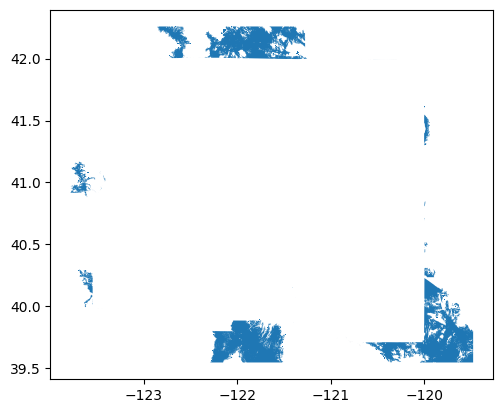

In [36]:
no_coverage_d2.plot()

In [ ]:
def sjoin_to_district_find_difference(
    tmobile: dg.GeoDataFrame, 
    district_df: gpd.GeoDataFrame
) -> dg.GeoDataFrame:
    tmobile_district = dg.sjoin(
        tmobile, 
        district_df, 
        how="inner", 
        predicate="intersects"
    ).drop(columns = "index_right")
    
    # Dissolve so that it's just 1 row for TMobile coverage in that district
    tmobile_diss = (tmobile_district.dissolve(by="district")
                    .reset_index()
                    .compute()
                   )
    
    # Maybe stash intermediate output here?
    d = district_df.district.iloc[0]
    tmobile_diss.to_parquet(f"tmobile_d{d}.parquet")
    
    # Instead of gpd.overlay(), since tmobile_diss is 1 row and 
    # district_df is 1 row,
    # can treat them as GeoSeries, align=True, to do row-wise comparison
    no_coverage = (tmobile_diss.difference(
            ct_all_districts[ct_all_districts.district==i], 
            align=True
        ).reset_index()
        .rename(columns = {0: 'geometry'})
    )   
    
    no_coverage.to_parquet(f"no_coverage_d{d}.parquet")
    
    return no_coverage


results = []

for i in [1]:
    dissolved_result = sjoin_to_district_find_difference(
        tmobile[["geometry"]], 
        ct_all_districts[ct_all_districts.district==i]
    )
    
    results.append(dissolved_result)


In [ ]:
ddf = dd.multi.concat(results, axis=0)

In [ ]:
df = ddf.compute()